# Demo Notebook to train, save, and load a model, which will be used on the Flask Webapp

# Problem Statement
To predict the presence of perceptual brand attributes in the images that consumers post online. 

## Multiclass Problem
It is a multiclass problem with a brand can be preceived with one of the 4 attributes : Fun, Healthy, Rugged or Glamarous

For current problem, we are follwing transfer learning approach to use pretrained resnet50 model and retrain the final layer 
with our the training data.

## Importing Libraries

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
try: 
  print('set memory growth')
  tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
  # Invalid device or cannot modify virtual devices once initialized. 
  pass 

set memory growth


In [68]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt
import cv2
import os


In [47]:
IMG_WIDTH=300
IMG_HEIGHT=300
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)

## Data preprocessing
We are going to do following data processing steps

 - Assign labels to images corresponding to the attribute dir from which images are read. We use one hot encoding to represent the attribure persence.
 - Remove corrupt images
 - label all the antonym negative on all attributes
 - Since we already have large amount of training images, we are not going to use any data augmentation technique.


In [ ]:
# Process all images in the attribute folders
# path to the downloaded flickr images
data_dir = 'C://Users//neera//Documents//Python Scripts//2nd_sem//DLS//data_code_submission//data//Flickr///Images_full//'
# We are looking for 4 positive and 4 negative attiribures for training the model
all_attributes = ['glamorous', 'rugged', 'healthy', 'fun']
all_antonyms = ['drab', 'gentle', 'unhealthy', 'dull']
num_attributes = len(all_attributes)

all_images = []
all_labels = []

label = 'negative'
for i in range(num_attributes):
    antonym_dir = data_dir + all_antonyms[i]
    r_images = [antonym_dir + '//' + f for f in os.listdir(antonym_dir)]
    for r in r_images:
        img = cv2.imread(r)
        if img is None: # We only keep good images
            continue
        all_images.append(r)
        all_labels.append(label)

# For each attribute, assign a label to the image. 
for i in range(num_attributes):
    attribute_dir = data_dir + all_attributes[i]
    r_images = [attribute_dir + '//' + f for f in os.listdir(attribute_dir)]
    
    label = all_attributes[i]
    for r in r_images:
        img = cv2.imread(r)
        if img is None: # We only keep good images
            continue
        all_images.append(r)
        all_labels.append(label)

In [75]:
print(len(all_images))
print(len(all_labels))

5132
5132


### Train-Test Split

 - We split the data set into training,validation and  testing data in ration of 80,10 and 10 percent


In [77]:
from sklearn.utils import shuffle
num_images = len(all_images)
shuffled_all_images, shuffled_all_labels, shuffled_id = \
    shuffle(all_images, all_labels, list(range(num_images)), random_state=66)

# As the images/labels are shuffled in the previous stage, they are 
# randomly ordered, so we will truncated the data directly into train, val, 
# and test

num_images = len(shuffled_all_images)
# number of 10% of all images
num_10_percent = int(num_images * 0.1)
print(num_10_percent)

train_80_images = shuffled_all_images[0:num_10_percent * 8]
train_labels = shuffled_all_labels[0:num_10_percent * 8]

val_10_images = shuffled_all_images[num_10_percent*8:num_10_percent*9]
val_labels = shuffled_all_labels[num_10_percent*8:num_10_percent*9]

test_10_images = shuffled_all_images[num_10_percent*9:]
test_labels = shuffled_all_labels[num_10_percent*9:]

print(len(train_80_images))
print(len(train_labels))
print(len(val_10_images))
print(len(val_labels))
print(len(test_10_images))
print(len(test_labels))

513
4104
4104
513
513
515
515


### Label Encoder
 - We encode the label values into one hot vector encoding using Sklearn library
 - Fit the label encoder using training labels
 - Transform Validation and Test labels 

In [78]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
np.unique(y_train)
num_class = max(y_train+1)
y_train = to_categorical(y_train,num_class)

y_test= label_encoder.transform(test_labels)
y_test = to_categorical(y_test,num_class)
y_val = label_encoder.transform(val_labels)
y_val = to_categorical(y_val,num_class)


## Load the images into ram along with the label


In [83]:
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_80_images]
train_imgs = np.array(train_imgs)
y_train = np.array(y_train)

validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in val_10_images]
validation_imgs = np.array(validation_imgs)
y_val = np.array(y_val)

test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_10_images]
test_imgs = np.array(test_imgs)
y_test = np.array(y_test)
validation_imgs.shape

(513, 300, 300, 3)

In [84]:
np.save('train', train_imgs)
np.save('train_label', y_train)
np.save('validation', validation_imgs)
np.save('validation_label', y_val)
np.save('test', test_imgs)
np.save('test_label', y_test)

## Model Implementation
 - We are going to use pre trained resnet model 
 - do not want to load the last fully connected layers which act as the classifier 
 - Freeze the weights of the model by setting trainable as false
 - add our own fully connected layers on top of the ResNet50 model for our task-specific classification.



In [85]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
# We do not want to load the last fully connected layers which act as the classifier we can add our 
# own fully connected layers on top of the ResNet50 model for our task-specific classification.

output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output=output)

#freeze the weights of the model by setting trainable as “False”
    
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

C:\Users\neera\anaconda3\envs\tf_gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

C:\Users\neera\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  import sys


## Add task specific fully connected layer to fine tune the model for classification purpose

In [86]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
input_shape=(IMG_HEIGHT,IMG_WIDTH,3)
model = Sequential()
model.add(restnet)
model.add(Dense(64, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 204800)            23587712  
_________________________________________________________________
dense_9 (Dense)              (None, 64)                13107264  
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 325       
Total params: 36,695,301
Trainable params: 13,107,589
Non-trainable params: 23,587,712
_________________________________________________________________


## Training

In [87]:

history = model.fit(train_imgs,
                    y_train,
                    epochs=2,
                    batch_size = 30,
                    validation_data=(validation_imgs,y_val) ,
                    verbose=1)

Train on 4104 samples, validate on 513 samples
Epoch 1/2
4104/4104 [==============================] - 124s 30ms/step - loss: 1.1827 - accuracy: 0.5989 - val_loss: 1.0354 - val_accuracy: 0.6491
Epoch 2/2
4104/4104 [==============================] - 121s 29ms/step - loss: 0.5790 - accuracy: 0.7961 - val_loss: 1.2737 - val_accuracy: 0.6413


## Testing

In [89]:
 def probabilty_to_classencoding(y_pred):
        """
        Output of softmax is probability distribution, 
        But we need the one hot encoding vector based on the class of 
        highest probabilty. 
        This function converts output of sigmoid to output class one hot encoding form
        """
        y_class = np.array( y_pred )
        idx = np.argmax(y_class, axis=-1)
        y_class = np.zeros(y_class.shape )
        y_class[ np.arange(y_class.shape[0]), idx] = 1
        return y_class
 def binary_class_to_label(binary_class):
        """
        Return the class value based on the one hot encoding vector
        """
        return(np.argmax(binary_class, axis=1))   

In [90]:
y_pred = model.predict(test_imgs)
y_pred = probabilty_to_classencoding(y_pred)
y_pred = binary_class_to_label(y_pred)
y_pred_labels = label_encoder.inverse_transform(y_pred)


In [92]:
print('Confusion Matrix')
cm = confusion_matrix(y_pred_labels, \
                      test_labels)
print(cm)

Confusion Matrix
[[180  25  40   9  92]
 [ 12  24   5   2   5]
 [  2   0   7   1   0]
 [  0   0   0   0   0]
 [  3   1   1   4 102]]


In [93]:
a = accuracy_score(y_pred_labels,test_labels)
print('Accuracy is:', a*100)

Accuracy is: 60.77669902912621


## Visualisation

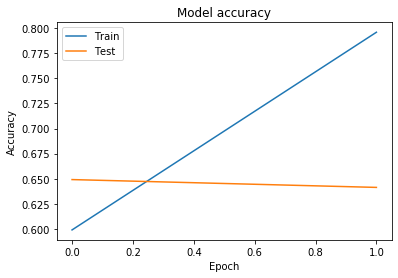

In [94]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

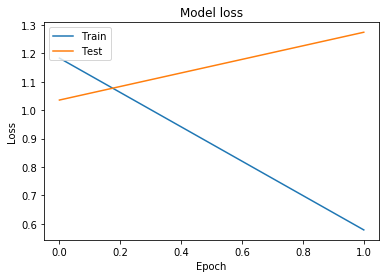

In [95]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

## Save Model

In [96]:
model.save('./playground/demo_model.h5')

In [98]:
model.save_weights('./checkpoints/my_checkpoint')

## Load Model

Imports and Data Preprocessing have to be executed, then the loaded model can be used for the Testing and Visualisation steps

In [ ]:
model = keras.models.load_model('./playground/demo_model.h5')